# Data Wrangling & EDA for Hemingway Next Word Prediction

## Introduction

Using *The Sun Also Rises* by Ernest Hemingway, this project will craft a next word prediction NLP object using Google's BERT. The wonderful venture Project Guttenberg (https://www.gutenberg.org/) provides free texts in electronic format. The text for this effort was chosen from Project Guttenberg and cleaned of its leading matter and liscence information.

## Table of Contents <a id="id0"></a>

1. [Import Packages](#id1)
2. [Load the Data](#id2)
3. [First Look Inside](#id3)
4. [Using spaCy for Initial Assessment](#id4)
5. [Frequency Counts for Nouns, Verbs, and Adjectives](#id5)
6. [Sentence Frequency by Word Count](#id6)
7. [Ngram Exploration](#id7)
8. [Word Embeddings](#id8)

<a id="id1"></a>

[Back to the TOC](#id0)


## Import Packages <a id="id1"></a>

In [1]:
import pandas as pd
import spacy
import spacy_cleaner
from spacy_cleaner.processing import removers, replacers, mutators
from spacy.matcher import Matcher
from nltk import bigrams
from nltk.tokenize import RegexpTokenizer
import nltk, re, string, collections
from nltk.lm import NgramCounter
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import seaborn as sns
from IPython.display import Image

[Back to the TOC](#id0)


## Load the Data <a id="id2"></a>

The novel *The Sun Also Rises* by Ernest Hemingway can be found at Project Gutenberg here: https://www.gutenberg.org/ebooks/67138 . 

In [2]:
### The Project Gutenberg information and publisher copyright information was removed manually with a text processing program.
# Loading the dataset
path = 'Sun_Also_Rises.txt'
text = open(path).read().lower()

print('The text has {:,} separate items'.format(len(text)))


The text has 364,517 separate items


[Back to the TOC](#id0)


<a id="id3"></a>
## First Look Inside

In [91]:
## Creating a Word Cloud function from unprocessed text of Sun Also Rises
def create_word_cloud(string):
   cloud = WordCloud(background_color = "white", max_words = 100,  stopwords = set(STOPWORDS))
   cloud.generate(string)
   cloud.to_file("wordCloud.png")
###Quick setup of the tokenizer from nltk
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

a= ' '.join(words) 

In [92]:
create_word_cloud(a)
##And creating a 2nd one with just 100 max_words which reads more cleanly

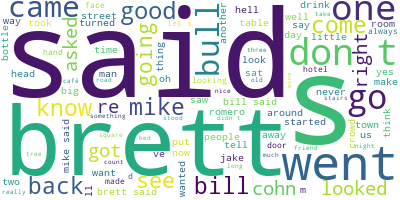

In [93]:
Image(filename="figures/Second_wordCloud.png")

In [94]:
## it looks like there are a lot of "s" hanging out by themselves, most likely the posessive 's' separated from removing and then spacing.
#How many of them as "words"? Same for free 't' of don't
def count_S(string):
    S_count = 0
    for item in (string):
        if item == "s":
            S_count += 1
    return S_count
s = count_S(a)
print("The count of free possesive Ses is {:,}".format(s))

def count_T(string):
    T_count = 0
    for item in (string):
        if item == "t":
            T_count += 1
    return T_count
t = count_T(a)
print("The count of free Tes is {:,}".format(t))

The count of free possesive Ses is 15,155
The count of free Tes is 26,404


[Back to the TOC](#id0)


## Using spaCy for Initial Assessment  <a id="id4"></a>

In [6]:
##Using spaCy to build an nlp pipeline
# Create a blank English nlp object
nlp = spacy.blank("en")

In [7]:
##checking to see if processing pipeline is up and running
doc = nlp("Hello world!")

# Iterate over tokens in a Doc
for token in doc:
    print(token.text)

Hello
world
!


In [97]:
#SAR will be the fullest text for "The Sun Also Rises"
SAR = nlp(text)
## Checking a random token from SAR
token2 = SAR[47]
span = SAR[147:156]
print(token2)
print(span)

sun
middleweight boxing champion of princeton. do not



In [98]:
### How much punctuation is there?
print("How many tokens are punctuation? {:,}".format(sum([token.is_punct for token in SAR])))

How many tokens are punctuation? 19,371


In [99]:
### How much numbers are there?
print("How many tokens are numbers? {:,}".format(sum([token.like_num for token in SAR])))

How many tokens are numbers? 748


In [100]:
### How many text-based words are there?
print("How many tokens are text words? {:,}".format(sum([token.is_alpha for token in SAR])))

How many tokens are text words? 68,315


In [87]:
### Working with their English pipeline (medium)
nlp = spacy.load("en_core_web_md")
nlp

In [102]:
SAR = nlp(text)

In [103]:
SAR[920:1000]



by that time, though, he had other things to worry about. he had been
taken in hand by a lady who hoped to rise with the magazine. she was
very forceful, and cohn never had a chance of not being taken in hand.
also he was sure that he loved her. when this lady saw that the magazine
was not going to rise, she became a little

In [104]:
### A quick check of how the pos parser is doing
span = SAR[100:125]
for token in span:
    print(token.text, token.pos_)

rivers NOUN
run VERB
into ADP

     SPACE
the DET
sea NOUN
; PUNCT
yet CCONJ
the DET
sea NOUN
is AUX
not PART
full ADJ
; PUNCT
unto ADP
the DET
place NOUN
from ADP
whence ADP
the DET

     SPACE
rivers NOUN
come VERB
, PUNCT
thither ADV


In [105]:
### looking at a few NER instances
for token in SAR.ents[100:125]:
    print(token.text, token.label_)
### dates, times, gpes, persons, org, and cardinal numbers seem to work well

two CARDINAL
spain GPE
south america LOC
british NORP
south america LOC
jewish NORP
jake PERSON
nearly half CARDINAL
about thirty-five years DATE
robert PERSON
one CARDINAL
south america LOC
robert PERSON
one CARDINAL
south america LOC
south america LOC
paris GPE
paris GPE
the quarter DATE
the quarter DATE
all one night TIME
night TIME
paris GPE
two CARDINAL
south america LOC


In [106]:
### Working with Matcher to find
matcher = Matcher(SAR.vocab)
pattern = [{"POS": "ADJ"}, {"TEXT": "men"}]
matcher.add("Adj_PATTERN", [pattern])
matches = matcher(SAR)

In [107]:
for match_id, start, end in matches:
    # Get the matched span
    matched_span = SAR[start:end]
    print(matched_span.text)

young men
young men
several men
more men
other men


In [108]:
### Doing the same for "women"
### Working with Matcher to find
matcher = Matcher(SAR.vocab)
pattern = [{"POS": "ADJ"}, {"TEXT": "women"}]
matcher.add("Adj_PATTERN", [pattern])
matches = matcher(SAR)

In [109]:
for match_id, start, end in matches:
    # Get the matched span
    matched_span = SAR[start:end]
    print(matched_span.text)

several women
american women


 Not a lot of adjective description in general here, and certainly fewer for women. Let's get a look at just ADJ + NOUN combos.

In [110]:
### Working with Matcher to find Adj and Noun combos
matcher = Matcher(SAR.vocab)
pattern = [{"POS": "ADJ"}, {"POS": "NOUN"}]
matcher.add("Adj_Noun", [pattern])
matches = matcher(SAR)

In [111]:
for match_id, start, end in matches[0:30]:
    # Get the matched span
    matched_span = SAR[start:end]
    print(matched_span.text)

lost generation
middleweight boxing
inner comfort
nice boy
young gentlemen
certain satisfaction
strange sort
last year
middleweight boxing
simple people
middleweight boxing
jewish families
military school
good end
nice boy
friendly boy
flattened nose
unattractive mould
domestic unhappiness
rich wife
healthful shock
literary people
short time
editorial page
sole editor
other things
literary friend
second year
careless possession
many people


Some telling pairings here. It would be good to look at the most common basic parts of speech.

In [112]:
print(sum(len(token) for token in SAR)/len(SAR))

3.1410961030895823


The word length average for SAR is quite short.

[Back to the TOC](#id0)

<a id="id5"></a>
## Frequency Counts for Nouns, Verbs, and Adjectives

In [113]:
### drawing from this TDS site: https://towardsdatascience.com/lovecraft-with-natural-language-processing-part-2-tokenisation-and-word-counts-f970f6ff5690
### Will use lemmatization here to get unified counts
def create_word_counts_by_pos(text, list_of_pos, word_count_dict_input = None):
    """
    takes a raw text file
    tokenizes and lemmatizes it
    limits inspection to list_of_pos types of words
    counts the individual lemmas
    returns a dictionary, keys are POSes in list_of_pos
    values are dictinaries with word counts
    """
    doc = nlp(text)
    
    if word_count_dict_input is None: 
        word_count_dict = {}
        for part_of_speech in list_of_pos:
            word_count_dict[part_of_speech] = {}
    else:
        word_count_dict = word_count_dict_input

    for token in doc: 
        part_of_speech = token.pos_

        if part_of_speech in list_of_pos:
            word_lemma = token.lemma_
            current_count = word_count_dict[part_of_speech].get(word_lemma, 0)
            current_count += 1
            word_count_dict[part_of_speech][word_lemma] = current_count

    return word_count_dict

def filter_word_count_dict_to_frequent(word_count_dict, threshold):
    """
    Loops through word_count_dict, only keeps items where 
    value is higher than a certain threshold
    """
    frequent_word_count_dict = {}

    list_of_pos = word_count_dict.keys()

    for part_of_speech in list_of_pos:
        frequent_word_count_dict[part_of_speech] = {}
        for key in word_count_dict[part_of_speech]:
            if word_count_dict[part_of_speech][key] > threshold:
                frequent_word_count_dict[part_of_speech][key] = \
                word_count_dict[part_of_speech][key]
                
    return frequent_word_count_dict

def collect_most_frequent_words(word_count_dict, number_to_collect):
    """
    word_count_dict is assumed to be in a format where keys are part-of-speech, 
    values are counts
    number_of_collect: we will collect this amount from each group
    if there is a tie: the one that appeared first
    """

    list_of_pos = word_count_dict.keys()
    most_frequent_words = {}

    for part_of_speech in list_of_pos:
        most_frequent_words[part_of_speech] = \
        sorted(word_count_dict[part_of_speech].items(), \
            key=lambda x: x[1], reverse = True)[:number_to_collect] 
        
    return most_frequent_words


In [114]:
list_of_pos = ['NOUN']

In [115]:
word_count_dict = create_word_counts_by_pos(text, list_of_pos)


In [116]:
frequent_word_count_dict = filter_word_count_dict_to_frequent(word_count_dict, 10)

In [117]:
nouns_df = pd.DataFrame.from_dict(frequent_word_count_dict)
nouns_df.iloc[5:10,:]

,NOUN
ass,13
back,27
bag,50
balcony,13
bar,45


In [118]:
### DOING THE SAME THE for verbs; Will assess data frames together
list_of_pos = ['VERB']

In [119]:
word_count_dict = create_word_counts_by_pos(text, list_of_pos)


In [120]:
frequent_word_count_dict = filter_word_count_dict_to_frequent(word_count_dict, 10)

In [121]:
verbs_df = pd.DataFrame.from_dict(frequent_word_count_dict)
verbs_df.head()

,VERB
ask,176
be,183
become,16
behave,11
believe,21


In [122]:
### DOING THE SAME THE for verbs; Will assess data frames together
list_of_pos = ['ADJ']

In [123]:
word_count_dict = create_word_counts_by_pos(text, list_of_pos)


In [124]:
frequent_word_count_dict = filter_word_count_dict_to_frequent(word_count_dict, 10)

In [125]:
adjs_df = pd.DataFrame.from_dict(frequent_word_count_dict)
adjs_df.head()

,ADJ
asleep,12
awful,13
bad,47
beautiful,12
big,76


In [126]:
print(nouns_df.shape, verbs_df.shape, adjs_df.shape)

(213, 1) (142, 1) (83, 1)


In [127]:
adjs_df.reset_index(inplace=True)

#verbs_df.reset_index(inplace=True)

In [128]:
adjs_df.columns

Index(['index', 'ADJ'], dtype='object')

In [ ]:
adjs_df.rename(columns={'index':'ADJ'}, inplace=True)
adjs_df.columns
#adjs_df.drop(columns=['level_0'], inplace=True)

adjs_df.sort_values('count', ascending=False).head()

In [ ]:
sns.barplot(x="ADJ", y='count', data=adjs_df.query('count > 25').sort_values('count', ascending=False))
sns.set(rc = {'figure.figsize':(20,10)})
plt.xlabel('Most Frequent Adjectives', fontsize=18)
plt.ylabel('Count of Adjectives', fontsize=18)
plt.xticks(rotation = 65, fontsize=18)
plt.savefig('Count for Frequent Adjectives')
plt.show()


In [ ]:
#nouns_df.reset_index(inplace=True)
nouns_df.drop("level_0", axis=1, inplace=True)
#nouns_df.drop([0,1], inplace=True)
nouns_df.head()

In [ ]:
nouns_df.rename(columns={'NOUN':'count', 'index':'Noun'}, inplace=True)

#nouns_df.sort_values('count', ascending=False).head()

### Issue here is that possessive 's' which is attached to nouns is itself counted as a frequent noun (77 times)
### Dropping it now and will figure out how to use it:
#nouns_df.drop([221], inplace=True)
nouns_df.sort_values('count',ascending=False).head(10)

In [ ]:
sns.barplot(x="Noun", y='count', data=nouns_df.query('count > 50').sort_values('count', ascending=False))
sns.set(rc = {'figure.figsize':(20,10)})
plt.xlabel('Most Frequent Nouns', fontsize=18)
plt.ylabel('Count of Nouns', fontsize=18)
plt.xticks(rotation = 60, fontsize=18)
plt.savefig('Count for Frequent Nouns')
plt.show()

### This one is really telling

In [ ]:
verbs_df.columns

In [ ]:
#verbs_df.rename(columns={'VERB':'count', 'index':'Verb'}, inplace=True)
#verbs_df.head()
#verbs_df.drop([138], inplace=True) ## The apostrophe
verbs_df.sort_values('count',ascending=False).head(10)
### Here the apostophe is considered a verb. Cute. I am sure it would be proud. But let's drop it.

In [ ]:
sns.barplot(x="Verb", y='count', data=verbs_df.query('count > 50').sort_values('count', ascending=False))
sns.set(rc = {'figure.figsize':(20,10)})
plt.xlabel('Most Frequent Verbs', fontsize=18)
plt.ylabel('Count of Verbs', fontsize=18)
plt.xticks(rotation = 60, fontsize=18)
plt.savefig('Count for Frequent Verbs')
plt.show()
### This one is really telling too; so many Old English verbs

[Back to the TOC](#id0)

<a id="id6"></a>
## Sentence Frequency by Word Count

Hemingway is known for a sparse, direct style. Clearly his nouns, verbs, and adjectives support that view considering the high rate of Old English vocabulary in his writing. Does the length of his sentences also create this writing style?

In [ ]:
### from https://spacy.io/usage/linguistic-features#sbd
assert SAR.has_annotation("SENT_START")
sentences = []
for sent in SAR.sents:
    sentences.append(sent.text)

In [ ]:
len(sentences)

In [ ]:
sent_df = pd.DataFrame(sentences)
sent_df.rename(columns={0:'sentence'}, inplace=True)
sent_df.head(10)

In [ ]:

sent_df['word count'] = sent_df['sentence'].apply(lambda x: len(x.split(' ')))


In [ ]:
### getting rid of the epigraphs for this purpose
#sent_df.drop(index=sent_df.index[:9], axis=0, inplace=True)
#sent_df.reset_index(inplace=True)
#sent_df.drop(columns='index', inplace=True)
sent_df.head(30)

In [ ]:
sent_df.sort_values('word count', ascending = False)

In [ ]:
sent_mean = np.around(np.mean(sent_df['word count']), decimals=2)
sent_std = np.around(np.std(sent_df['word count']), decimals=2)
sent_range = np.max(sent_df['word count']) - min(sent_df['word count'])
print('The mean word count per sentence is {}, \n the standard deviation is {}, \n and the range is {}'\
      .format(sent_mean, sent_std, sent_range))

In [ ]:
sns.histplot(data=sent_df, x="word count", bins=20, kde=True);
plt.xlabel('Bins of Words per Sentence', fontsize=18)
plt.ylabel('Count of Sentences', fontsize=18)
plt.xticks(rotation = 0, fontsize=18)
plt.savefig('Histogram of word count per sentence')

In [ ]:
sns.histplot(data=sent_df, x="word count", bins=10, kde=True, log_scale=True);
plt.xlabel('Bins of Words per Sentence', fontsize=18)
plt.ylabel('Count of Sentences', fontsize=18)
plt.xticks(rotation = 0, fontsize=18)
plt.savefig('Histogram of log transformed word count per sentence')

The log transformed word count per sentence provides a more coherent view of the variability for sentence length.

[Back to the TOC](#id0)

In [142]:
### Saving Text5 which is the one tokenizd for further work
f = open("text_clean.txt", "w")
f.write(text5)
f.close()